In [9]:
import sys
sys.path.append("../DeepHypergraph/") 

In [10]:
import time
from copy import deepcopy

from utils import *
from data import LinkPredictDataset

from dhg import Hypergraph

In [11]:
msg_pass_ratio:float = 0.7
data_set = LinkPredictDataset("data_s7000_p5_t1000_hs11_e100000", ratio=(msg_pass_ratio, 1-msg_pass_ratio), device=torch.device("cpu"))

In [12]:
print(f"original_hg : {zero_dergee_num(data_set.original_hg)}")
print(f"msg_pass_hg : {zero_dergee_num(data_set.msg_pass_hg)}")
print(f"pos_hg : {zero_dergee_num(data_set.pos_hg)}")
print(f"neg_hg : {zero_dergee_num(data_set.neg_hg)}")

original_hg : 2
msg_pass_hg : 2
pos_hg : 4
neg_hg : 0


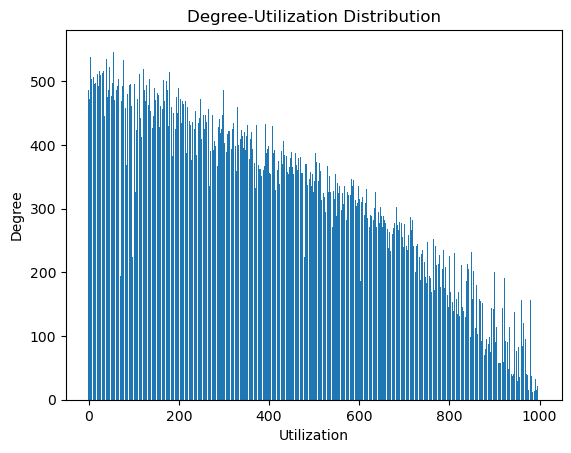

In [13]:
plot_dergee_utilization(data_set.original_hg)

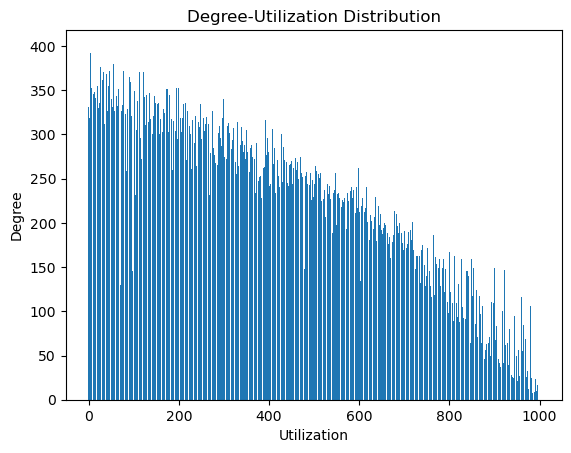

In [14]:
plot_dergee_utilization(data_set.msg_pass_hg)

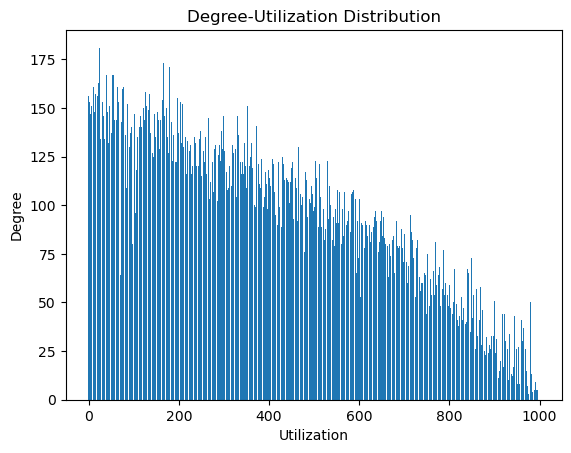

In [15]:
plot_dergee_utilization(data_set.pos_hg)

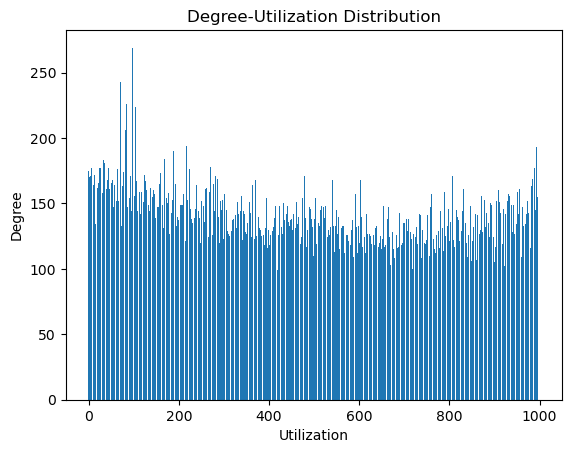

In [16]:
plot_dergee_utilization(data_set.neg_hg)